In [8]:
%config InlineBackend.figure_formats = ['svg']
import torch
import numpy as np
import sys; sys.path.append('../src/'); sys.path.append('..')
import matplotlib.pyplot as plt
import glob
import os
import matplotlib.ticker as mtick

In [11]:
plt.style.use('./style.mplstyle')

# Main
##  Syn

In [3]:
def load_metrics(dir, metrics, prefix=''):
    return [np.load(os.path.join(dir, '{}{}.npy'.format(prefix, metric))) for metric in metrics]

In [4]:
def dr_rank(l2_cum_a, l2_non, l2_all, delta=0.01):
    exp_rec = (l2_cum_a.T - l2_non) / (l2_all - l2_non)
    return (exp_rec >= delta).sum(0)

def exprec_each(l2_each, l2_non, l2_all):
    exp_rec = (l2_each.T - l2_non) / (l2_all - l2_non)
    return exp_rec.T

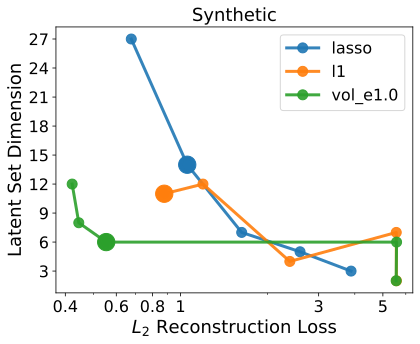

In [12]:
src = '../saves/image/'
dataset_name = 'syn'


lams = np.asarray([1e-2, 3e-3, 1e-3, 3e-4, 1e-4])
prefixes = ['', '', 'e1.0_']
suffixes = ['', '', '_e1.0']
metrics = ['l2_non', 'l2_all', 'l2_cum_a', 'l2_each', 'z_std']
groups = ['lasso', 'l1', 'vol']
ii = [-2, -1, -3]

for group, prefix, suffix, i in zip(groups, prefixes, suffixes, ii):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
    plt.plot(l2_non, rank, 'o-', label=group+suffix, alpha=0.9)
    plt.scatter(l2_non[i], rank[i], marker='o', s=300)

# plt.yticks(np.arange(0, 26, 2))
plt.xscale('log')
plt.xticks([0.4, 0.6, 0.8, 1, 3, 5], [0.4, 0.6, 0.8, 1, 3, 5])
plt.legend()
plt.xlabel('$L_2$ Reconstruction Loss')
plt.ylabel('Latent Set Dimension')
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.title('Synthetic')
plt.show()

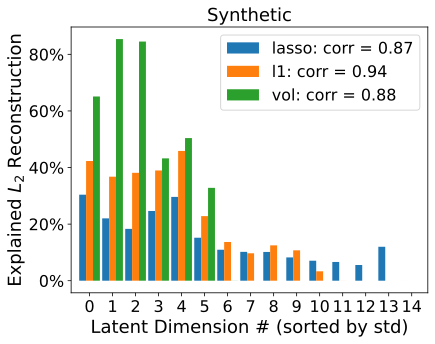

In [56]:
width = 0.3
rs = []
for group, prefix, idx, n in zip(groups, prefixes, [-2, -1, -3], range(3)):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    er_e = exprec_each(l2_each, l2_non, l2_all)
    r = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)[idx]; rs.append(r)
    coef = np.corrcoef(z_std[idx, :r+1], er_e[idx, :r+1])[0, 1]
    plt.bar(np.arange(len(er_e[idx])) + n*width, er_e[idx], width=width, label=group+': corr = {:.2f}'.format(coef))
plt.legend()
# plt.gcf().set_size_inches(7, 5)
plt.xlabel('Latent Dimension # (sorted by std)')
plt.ylabel('Explained $L_2$ Reconstruction')
plt.xlim(-0.5, max(rs)+1)
plt.xticks(np.arange(max(rs)+1)+width, np.arange(max(rs)+1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.title('Synthetic')
plt.show()

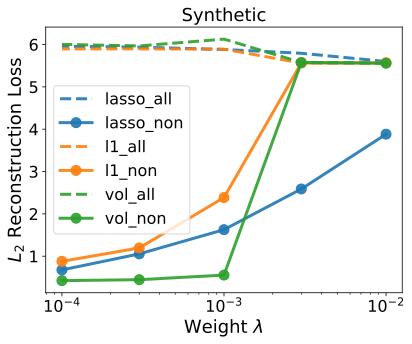

In [57]:
for group, prefix, suffix, color in zip(groups, prefixes, suffixes, ['tab:blue', 'tab:orange', 'tab:green']):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    plt.plot(lams, l2_all, '--', label=group+'_all', c=color, alpha=0.9)
    plt.plot(lams, l2_non, 'o-', label=group+'_non', c=color, alpha=0.9)

# plt.yticks(np.arange(0, 26, 2))
plt.xscale('log')
plt.legend()
plt.xlabel('Weight $\lambda$')
plt.ylabel('$L_2$ Reconstruction Loss')
plt.title('Synthetic')
plt.show()

## MNIST

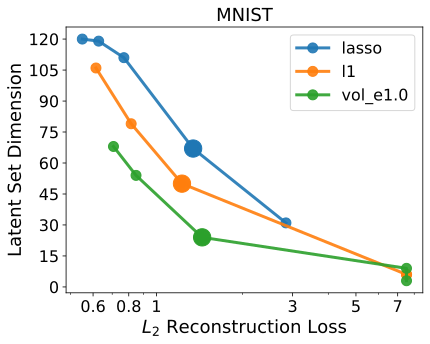

In [58]:
src = '../saves/image/'
dataset_name = 'mnist'

lams = np.asarray([3e-2, 1e-2, 3e-3, 1e-3, 3e-4])
prefixes = ['', '', 'e1.0_']
suffixes = ['', '', '_e1.0']
metrics = ['l2_non', 'l2_all', 'l2_cum_a', 'l2_each', 'z_std']
groups = ['lasso', 'l1', 'vol']
ii = [-4, -3, -3]

for group, prefix, suffix, i in zip(groups, prefixes, suffixes, ii):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
    plt.plot(l2_non, rank, 'o-', label=group+suffix, alpha=0.9)
    plt.scatter(l2_non[i], rank[i], marker='o', s=300)

# plt.yticks(np.arange(0, 125, 5))
plt.xscale('log')
plt.xticks([0.6, 0.8, 1, 3, 5, 7], [0.6, 0.8, 1, 3, 5, 7])
plt.legend()
plt.xlabel('$L_2$ Reconstruction Loss')
plt.ylabel('Latent Set Dimension')
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.title('MNIST')
plt.show()

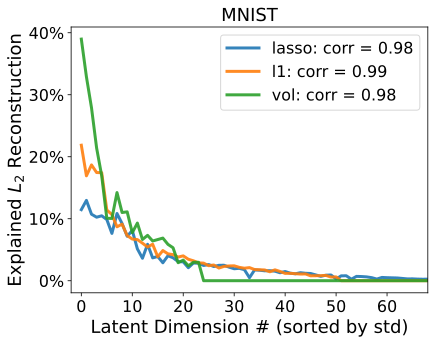

In [59]:
width = 0.3
rs = []
for group, prefix, idx, n in zip(groups, prefixes, [-4, -3, -3], range(3)):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    er_e = exprec_each(l2_each, l2_non, l2_all)
    r = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)[idx]; rs.append(r)
    coef = np.corrcoef(z_std[idx, :r+1], er_e[idx, :r+1])[0, 1]
    plt.plot(np.arange(len(er_e[idx])), er_e[idx], label=group+': corr = {:.2f}'.format(coef), alpha=0.9)
    # plt.bar(np.arange(len(er_e[idx])) + n*width, er_e[idx], width=width, label=group+': corr = {:.2f}'.format(coef))
plt.legend()
# plt.gcf().set_size_inches(7, 5)
plt.xlabel('Latent Dimension # (sorted by std)')
plt.ylabel('Explained $L_2$ Reconstruction')
# plt.xlim(-0.5, max(rs)+5)
plt.xlim(-2, max(rs)+1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
plt.title('MNIST')
plt.show()

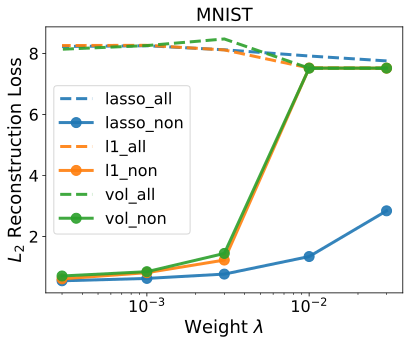

In [60]:
for group, prefix, suffix, color in zip(groups, prefixes, suffixes, ['tab:blue', 'tab:orange', 'tab:green']):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    plt.plot(lams, l2_all, '--', label=group+'_all', c=color, alpha=0.9)
    plt.plot(lams, l2_non, 'o-', label=group+'_non', c=color, alpha=0.9)

# plt.yticks(np.arange(0, 26, 2))
plt.xscale('log')
plt.legend()
plt.xlabel('Weight $\lambda$')
plt.ylabel('$L_2$ Reconstruction Loss')
plt.title('MNIST')
plt.show()

## CIFAR10

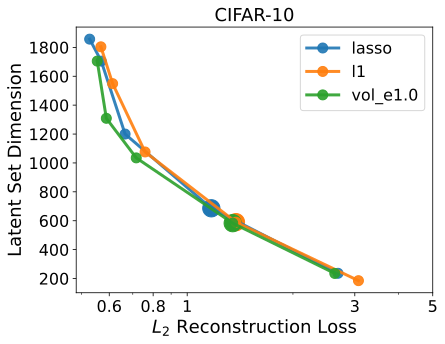

In [61]:
src = '../saves/image/'
dataset_name = 'cifar10'


lams = np.asarray([3e-2, 1e-2, 3e-3, 1e-3, 3e-4])
prefixes = ['', '', 'e1.0_']
suffixes = ['', '', '_e1.0']
metrics = ['l2_non', 'l2_all', 'l2_cum_a', 'l2_each', 'z_std']
groups = ['lasso', 'l1', 'vol']
ii = [1,1,1]

for group, prefix, suffix, i in zip(groups, prefixes, suffixes, ii):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    rank = dr_rank(l2_cum_a, l2_non, l2_all, delta=0.01)
    plt.plot(l2_non, rank, 'o-', label=group+suffix, alpha=0.9)
    plt.scatter(l2_non[i], rank[i], marker='o', s=300)

# plt.yticks(np.arange(0, 100, 5))
plt.xscale('log')
plt.xticks([0.6, 0.8, 1, 3, 5], [0.6, 0.8, 1, 3, 5])
plt.legend()
plt.xlabel('$L_2$ Reconstruction Loss')
plt.ylabel('Latent Set Dimension')
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.title('CIFAR-10')
plt.show()

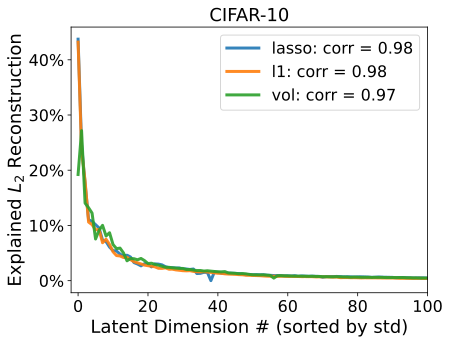

In [62]:
width = 0.3
rs = []
for group, prefix, idx, n in zip(groups, prefixes, [1,1,1], range(3)):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    er_e = exprec_each(l2_each, l2_non, l2_all)
    r = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)[idx]; rs.append(r)
    coef = np.corrcoef(z_std[idx, :r+1], er_e[idx, :r+1])[0, 1]
    plt.plot(np.arange(len(er_e[idx])), er_e[idx], label=group+': corr = {:.2f}'.format(coef), alpha=0.9)
    # plt.bar(np.arange(len(er_e[idx])) + n*width, er_e[idx], width=width, label=group+': corr = {:.2f}'.format(coef))
plt.legend()
# plt.gcf().set_size_inches(7, 5)
plt.xlabel('Latent Dimension # (sorted by std)')
plt.ylabel('Explained $L_2$ Reconstruction')
plt.xlim(-2, 100)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
plt.title('CIFAR-10')
plt.show()

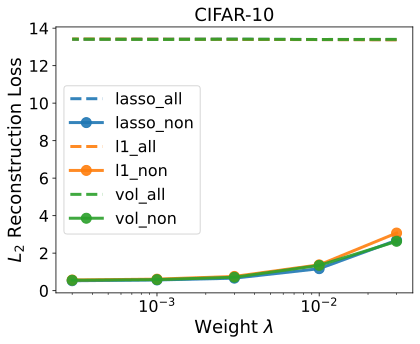

In [63]:
for group, prefix, suffix, color in zip(groups, prefixes, suffixes, ['tab:blue', 'tab:orange', 'tab:green']):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    plt.plot(lams, l2_all, '--', label=group+'_all', c=color, alpha=0.9)
    plt.plot(lams, l2_non, 'o-', label=group+'_non', c=color, alpha=0.9)

# plt.yticks(np.arange(0, 26, 2))
plt.xscale('log')
plt.legend()
plt.xlabel('Weight $\lambda$')
plt.ylabel('$L_2$ Reconstruction Loss')
plt.title('CIFAR-10')
plt.show()

# Ablation
## No Lip
### Syn

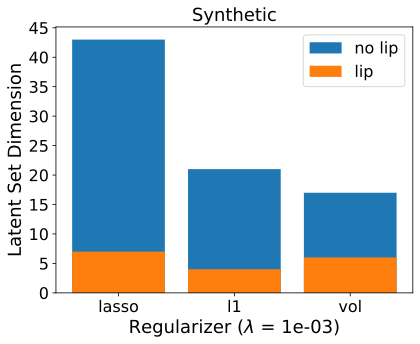

['37.037~77.724', '46.669~101.602', '105.191~1062.098'] ['0.015~0.224', '0.010~0.436', '0.013~0.741']


In [31]:
src = '../saves/image/'
dataset_name = 'syn'


lams = np.asarray([1e-2, 3e-3, 1e-3, 3e-4, 1e-4])

suffixes = ['', '', '_e1.0']
metrics = ['l2_non', 'l2_all', 'l2_cum_a', 'l2_each', 'z_std']

prefixes = ['', '', 'e1.0_']
groups = ['lasso', 'l1', 'vol']
rs1 = []; tt1 = []
i=2
for group, prefix, suffix in zip(groups, prefixes, suffixes):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
    rs1.append(rank[i])
    ss = z_std[i][:rank[i]]
    tt1.append('{:.3f}~{:.3f}'.format(ss.min(), ss.max()).replace("e-0", "e-").replace("e+0", "e+"))
rs1 = np.asarray(rs1)

prefixes = ['lasso', 'l1', 'vol']
group = 'nolip'
rs2 = []; tt2 = []
for prefix, suffix in zip(prefixes, suffixes):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix+'_')
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
    rs2.append(rank[0])
    ss = z_std[0][:rank[0]]
    tt2.append('{:.3f}~{:.3f}'.format(ss.min(), ss.max()).replace("e-0", "e-").replace("e+0", "e+"))
rs2 = np.asarray(rs2)
    
bb = plt.bar(np.arange(3), rs2, label='no lip')
# plt.bar_label(bb, tt2, fontsize=14, padding=-2)
bb = plt.bar(np.arange(3), rs1, label='lip')
# plt.bar_label(bb, tt1, color='white', fontsize=14, padding=-2)

plt.legend()
plt.xlabel('Regularizer ($\lambda$ = {:.0e})'.format(lams[2]))
plt.xticks(np.arange(3), groups)
plt.ylabel('Latent Set Dimension')
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.title('Synthetic')
plt.show()

print(tt1, tt2)

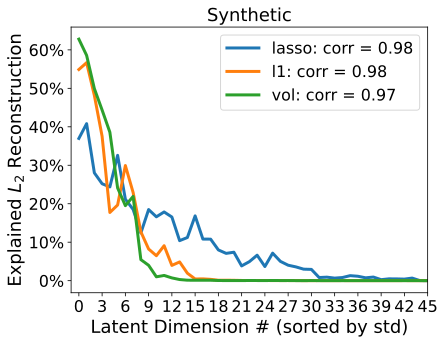

In [65]:
rs = []
for prefix, idx, n in zip(prefixes, [0, 0, 0], range(3)):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix+'_')
    er_e = exprec_each(l2_each, l2_non, l2_all)
    r = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)[idx]; rs.append(r)
    coef = np.corrcoef(z_std[idx, :r+1], er_e[idx, :r+1])[0, 1]
    plt.plot(np.arange(len(er_e[idx])), er_e[idx], label=prefix+': corr = {:.2f}'.format(coef))
    # plt.bar(np.arange(len(er_e[idx])) + n*width, er_e[idx], width=width, label=group+': corr = {:.2f}'.format(coef))
plt.legend()
plt.xlabel('Latent Dimension # (sorted by std)')
plt.ylabel('Explained $L_2$ Reconstruction')
plt.xlim(-1, max(rs)+1)
plt.xticks(np.arange(0, max(rs)+5, 3), np.arange(0, max(rs)+5, 3))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.title('Synthetic')
plt.show()

### MNIST

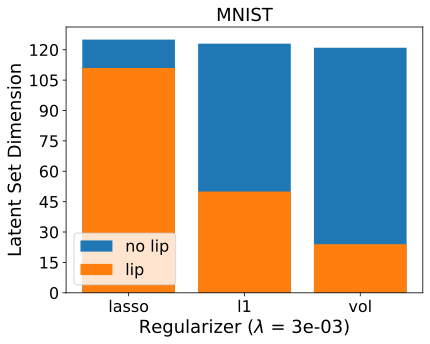

['0.882~22.154', '3.116~29.064', '34.423~230.085'] ['0.013~0.058', '0.012~0.050', '0.010~0.126']


In [32]:
src = '../saves/image/'
dataset_name = 'mnist'


lams = np.asarray([3e-2, 1e-2, 3e-3, 1e-3, 3e-4])

suffixes = ['', '', '_e1.0']
metrics = ['l2_non', 'l2_all', 'l2_cum_a', 'l2_each', 'z_std']

prefixes = ['', '', 'e1.0_']
groups = ['lasso', 'l1', 'vol']
rs1 = []; tt1 = []
i=2
for group, prefix, suffix in zip(groups, prefixes, suffixes):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
    rs1.append(rank[i])
    ss = z_std[i][:rank[i]]
    tt1.append('{:.3f}~{:.3f}'.format(ss.min(), ss.max()).replace("e-0", "e-").replace("e+0", "e+"))
rs1 = np.asarray(rs1)

prefixes = ['lasso', 'l1', 'vol']
group = 'nolip'
rs2 = []; tt2 = []
for prefix, suffix in zip(prefixes, suffixes):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix+'_')
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
    rs2.append(rank[0])
    ss = z_std[0][:rank[0]]
    tt2.append('{:.3f}~{:.3f}'.format(ss.min(), ss.max()).replace("e-0", "e-").replace("e+0", "e+"))
rs2 = np.asarray(rs2)
    
bb = plt.bar(np.arange(3), rs2, label='no lip')
# plt.bar_label(bb, tt2, fontsize=14, padding=-2)
bb = plt.bar(np.arange(3), rs1, label='lip')
# plt.bar_label(bb, tt1, color='white', fontsize=14, padding=-2)

plt.legend(loc='lower left')
plt.xlabel('Regularizer ($\lambda$ = {:.0e})'.format(lams[2]))
plt.xticks(np.arange(3), groups)
plt.ylabel('Latent Set Dimension')
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.title('MNIST')
plt.show()

print(tt1, tt2)

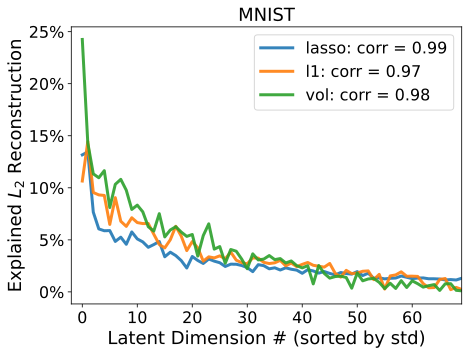

In [67]:
width = 0.3
rs = []
for prefix, idx, n in zip(prefixes, [0, 0, 0], range(3)):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix+'_')
    er_e = exprec_each(l2_each, l2_non, l2_all)
    r = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)[idx]; rs.append(r)
    coef = np.corrcoef(z_std[idx, :r+1], er_e[idx, :r+1])[0, 1]
    plt.plot(np.arange(len(er_e[idx])), er_e[idx], label=prefix+': corr = {:.2f}'.format(coef), alpha=0.9)
    # plt.bar(np.arange(len(er_e[idx])) + n*width, er_e[idx], width=width, label=group+': corr = {:.2f}'.format(coef))
plt.legend()
plt.gcf().set_size_inches(7, 5)
plt.xlabel('Latent Dimension # (sorted by std)')
plt.ylabel('Explained $L_2$ Reconstruction')
# plt.xlim(-0.5, max(rs)+5)
plt.xlim(-2, 69)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
plt.title('MNIST')
plt.show()

### CIFAR10

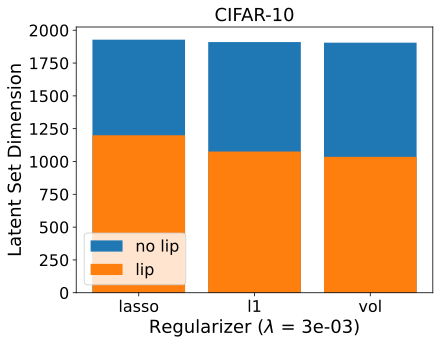

['0.166~51.530', '0.200~50.716', '0.208~91.223'] ['0.006~0.106', '0.004~0.100', '0.005~0.117']


In [33]:
src = '../saves/image/'
dataset_name = 'cifar10'


lams = np.asarray([3e-2, 1e-2, 3e-3, 1e-3, 3e-4])

suffixes = ['', '', '_e1.0']
metrics = ['l2_non', 'l2_all', 'l2_cum_a', 'l2_each', 'z_std']

prefixes = ['', '', 'e1.0_']
groups = ['lasso', 'l1', 'vol']
rs1 = []; tt1 = []
i=2
for group, prefix, suffix in zip(groups, prefixes, suffixes):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
    rs1.append(rank[i])
    ss = z_std[i][:rank[i]]
    tt1.append('{:.3f}~{:.3f}'.format(ss.min(), ss.max()).replace("e-0", "e-").replace("e+0", "e+"))
rs1 = np.asarray(rs1)

prefixes = ['lasso', 'l1', 'vol']
group = 'nolip'
rs2 = []; tt2 = []
for prefix, suffix in zip(prefixes, suffixes):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix+'_')
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
    rs2.append(rank[0])
    ss = z_std[0][:rank[0]]
    tt2.append('{:.3f}~{:.3f}'.format(ss.min(), ss.max()).replace("e-0", "e-").replace("e+0", "e+"))
rs2 = np.asarray(rs2)
    
bb = plt.bar(np.arange(3), rs2, label='no lip')
# plt.bar_label(bb, tt2, fontsize=14, padding=-2)
bb = plt.bar(np.arange(3), rs1, label='lip')
# plt.bar_label(bb, tt1, color='white', fontsize=14, padding=-2)

plt.legend(loc='lower left')
plt.xlabel('Regularizer ($\lambda$ = {:.0e})'.format(lams[2]))
plt.xticks(np.arange(3), groups)
plt.ylabel('Latent Set Dimension')
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.title('CIFAR-10')
plt.show()

print(tt1, tt2)

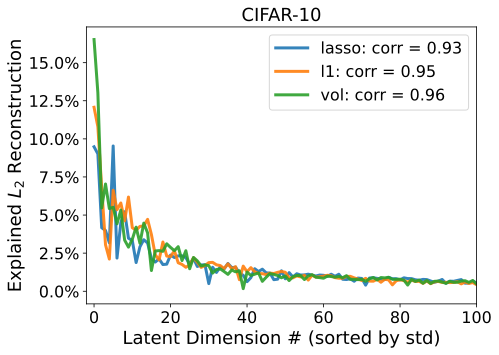

In [69]:
width = 0.3
rs = []
for prefix, idx, n in zip(prefixes, [0, 0, 0], range(3)):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix+'_')
    er_e = exprec_each(l2_each, l2_non, l2_all)
    r = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)[idx]; rs.append(r)
    coef = np.corrcoef(z_std[idx, :r+1], er_e[idx, :r+1])[0, 1]
    plt.plot(np.arange(len(er_e[idx])), er_e[idx], label=prefix+': corr = {:.2f}'.format(coef), alpha=0.9)
plt.legend()
plt.gcf().set_size_inches(7, 5)
plt.xlabel('Latent Dimension # (sorted by std)')
plt.ylabel('Explained $L_2$ Reconstruction')
plt.xlim(-2, 100)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.title('CIFAR-10')
plt.show()

## No Sparsity
### Synthetic

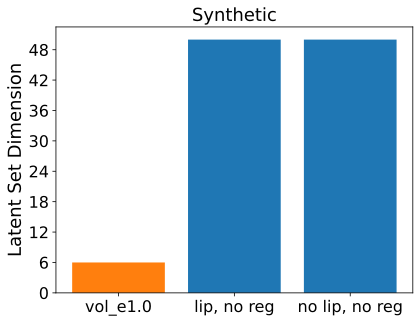

['2471.752~6047.698', '4.814~11.432']


In [37]:
src = '../saves/image/'
dataset_name = 'syn'


lams = np.asarray([1e-2, 3e-3, 1e-3, 3e-4, 1e-4])
prefixes = ['True', 'False']
suffixes = ['', '']
metrics = ['l2_non', 'l2_all', 'l2_cum_a', 'l2_each', 'z_std']
group = 'non'

l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(os.path.join(src, dataset_name, 'vol'), metrics, 'e1.0_')
rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
rr = [rank[2]]
tt1 = []
for prefix, suffix in zip(prefixes, suffixes):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix+'_')
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01).item()
    ss = z_std[:rank]
    tt1.append('{:.3f}~{:.3f}'.format(ss.min(), ss.max()).replace("e-0", "e-").replace("e+0", "e+"))
    rr.append(rank)

plt.bar(np.arange(3), rr, color=['tab:orange', 'tab:blue', 'tab:blue'])
plt.xticks(np.arange(3), ['vol_e1.0', 'lip, no reg', 'no lip, no reg'])
# plt.xlabel('$L_2$ Reconstruction Loss')
plt.ylabel('Latent Set Dimension')
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.title('Synthetic')
plt.show()
print(tt1)

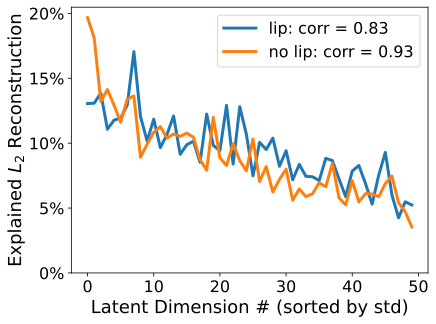

In [25]:
width = 0.3
rs = []
for prefix, idx, n in zip(prefixes, [0, 0, 0], range(3)):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix+'_')
    er_e = exprec_each(l2_each, l2_non, l2_all)
    r = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)[idx]; rs.append(r)
    coef = np.corrcoef(z_std[idx, :r+1], er_e[idx, :r+1])[0, 1]
    # plt.bar(np.arange(len(er_e[idx])) + n*width, er_e[idx], width=width, label=group+': corr = {:.2f}'.format(coef))
    name = 'lip' if prefix=='True' else 'no lip'
    plt.plot(np.arange(len(er_e[idx])), er_e[idx], label=name+': corr = {:.2f}'.format(coef))
plt.legend()
plt.xlabel('Latent Dimension # (sorted by std)')
plt.ylabel('Explained $L_2$ Reconstruction')
plt.ylim(0, None)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
plt.show()

### MNIST

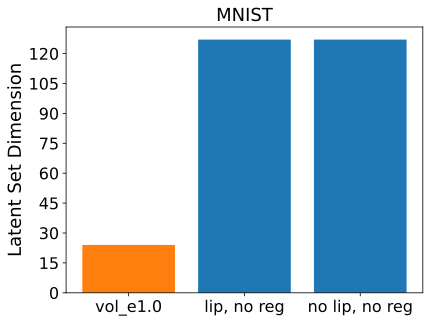

['81.944~170.874', '0.913~2.407']


In [40]:
src = '../saves/image/'
dataset_name = 'mnist'

lams = np.asarray([3e-2, 1e-2, 3e-3, 1e-3, 3e-4])
prefixes = ['True', 'False']
suffixes = ['', '']
metrics = ['l2_non', 'l2_all', 'l2_cum_a', 'l2_each', 'z_std']
group = 'non'

l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(os.path.join(src, dataset_name, 'vol'), metrics, 'e1.0_')
rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
rr = [rank[2]]
tt1 = []
for prefix, suffix in zip(prefixes, suffixes):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix+'_')
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01).item()
    ss = z_std[:rank]
    tt1.append('{:.3f}~{:.3f}'.format(ss.min(), ss.max()).replace("e-0", "e-").replace("e+0", "e+"))
    rr.append(rank)

plt.bar(np.arange(3), rr, color=['tab:orange', 'tab:blue', 'tab:blue'])
plt.xticks(np.arange(3), ['vol_e1.0', 'lip, no reg', 'no lip, no reg'])
# plt.xlabel('$L_2$ Reconstruction Loss')
plt.ylabel('Latent Set Dimension')
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.title('MNIST')
plt.show()

print(tt1)

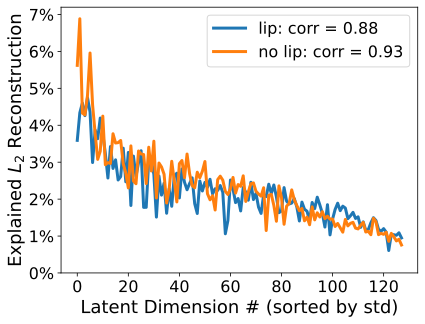

In [28]:
width = 0.3
rs = []
for prefix, idx, n in zip(prefixes, [0, 0, 0], range(3)):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix+'_')
    er_e = exprec_each(l2_each, l2_non, l2_all)
    r = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)[idx]; rs.append(r)
    coef = np.corrcoef(z_std[idx, :r+1], er_e[idx, :r+1])[0, 1]
    name = 'lip' if prefix=='True' else 'no lip'
    plt.plot(np.arange(len(er_e[idx])), er_e[idx], label=name+': corr = {:.2f}'.format(coef))
plt.legend()
plt.xlabel('Latent Dimension # (sorted by std)')
plt.ylabel('Explained $L_2$ Reconstruction')
plt.ylim(0, None)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
plt.show()

### CIFAR

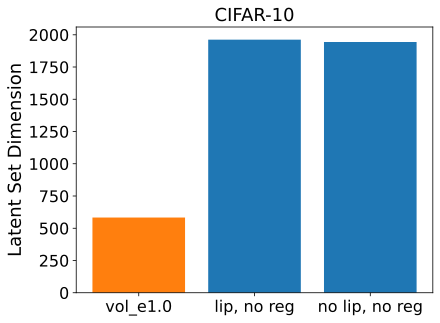

['29.329~881.899', '0.096~3.169']


In [41]:
src = '../saves/image/'
dataset_name = 'cifar10'

lams = np.asarray([3e-2, 1e-2, 3e-3, 1e-3, 3e-4])
prefixes = ['True', 'False']
suffixes = ['', '']
metrics = ['l2_non', 'l2_all', 'l2_cum_a', 'l2_each', 'z_std']
group = 'non'

l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(os.path.join(src, dataset_name, 'vol'), metrics, 'e1.0_')
rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
rr = [rank[1]]
tt1 = []
for prefix, suffix in zip(prefixes, suffixes):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix+'_')
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01).item()
    ss = z_std[:rank]
    tt1.append('{:.3f}~{:.3f}'.format(ss.min(), ss.max()).replace("e-0", "e-").replace("e+0", "e+"))
    rr.append(rank)

plt.bar(np.arange(3), rr, color=['tab:orange', 'tab:blue', 'tab:blue'])
plt.xticks(np.arange(3), ['vol_e1.0', 'lip, no reg', 'no lip, no reg'])
# plt.xlabel('$L_2$ Reconstruction Loss')
plt.ylabel('Latent Set Dimension')
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.title('CIFAR-10')
plt.show()

print(tt1)

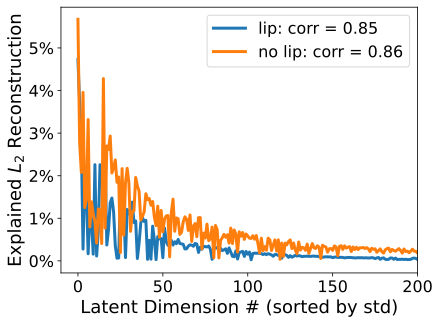

In [75]:
width = 0.3
rs = []
for prefix, idx, n in zip(prefixes, [0, 0, 0], range(3)):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix+'_')
    er_e = exprec_each(l2_each, l2_non, l2_all)
    r = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)[idx]; rs.append(r)
    coef = np.corrcoef(z_std[idx, :r+1], er_e[idx, :r+1])[0, 1]
    name = 'lip' if prefix=='True' else 'no lip'
    plt.plot(np.arange(len(er_e[idx])), er_e[idx], label=name+': corr = {:.2f}'.format(coef))
plt.legend()
plt.xlabel('Latent Dimension # (sorted by std)')
plt.ylabel('Explained $L_2$ Reconstruction')
plt.xlim(-10, 200)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
plt.show()

# Sensitivity

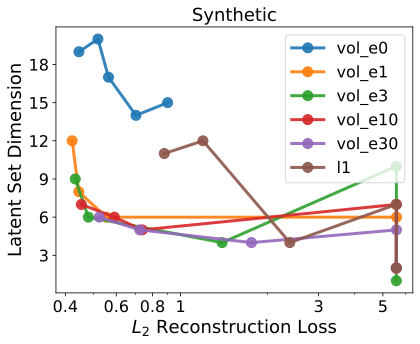

In [16]:
src = '../saves/image/'
dataset_name = 'syn'


lams = np.asarray([1e-2, 3e-3, 1e-3, 3e-4, 1e-4])
prefixes = ['e0.0_', 'e1.0_', 'e3.0_', 'e10.0_', 'e30.0_']
suffixes = ['_e0', '_e1', '_e3', '_e10', '_e30']
metrics = ['l2_non', 'l2_all', 'l2_cum_a', 'l2_each', 'z_std']
group = 'vol'

for prefix, suffix in zip(prefixes, suffixes):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
    plt.plot(l2_non, rank, 'o-', label=group+suffix, alpha=0.9)

dir = os.path.join(src, dataset_name, 'l1')
l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, '')
rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
plt.plot(l2_non, rank, 'o-', label='l1', alpha=0.9)

# plt.yticks(np.arange(0, 26, 2))
plt.xscale('log')
plt.xticks([0.4, 0.6, 0.8, 1, 3, 5], [0.4, 0.6, 0.8, 1, 3, 5])
plt.legend()
plt.xlabel('$L_2$ Reconstruction Loss')
plt.ylabel('Latent Set Dimension')
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.title('Synthetic')
plt.show()

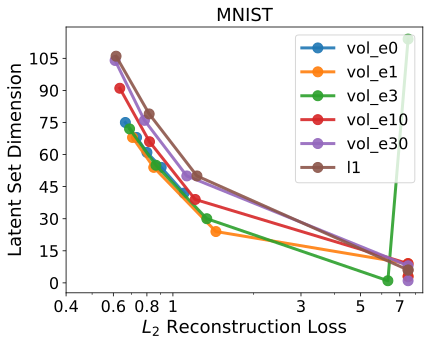

In [17]:
src = '../saves/image/'
dataset_name = 'mnist'


lams = np.asarray([1e-2, 3e-3, 1e-3, 3e-4, 1e-4])
prefixes = ['e0.0_', 'e1.0_', 'e3.0_', 'e10.0_', 'e30.0_']
suffixes = ['_e0', '_e1', '_e3', '_e10', '_e30']
metrics = ['l2_non', 'l2_all', 'l2_cum_a', 'l2_each', 'z_std']
group = 'vol'

for prefix, suffix in zip(prefixes, suffixes):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
    plt.plot(l2_non, rank, 'o-', label=group+suffix, alpha=0.9)

dir = os.path.join(src, dataset_name, 'l1')
l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, '')
rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
plt.plot(l2_non, rank, 'o-', label='l1', alpha=0.9)

# plt.yticks(np.arange(0, 26, 2))
plt.xscale('log')
plt.xticks([0.4, 0.6, 0.8, 1, 3, 5, 7], [0.4, 0.6, 0.8, 1, 3, 5, 7])
plt.legend()
plt.xlabel('$L_2$ Reconstruction Loss')
plt.ylabel('Latent Set Dimension')
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.title('MNIST')
plt.show()

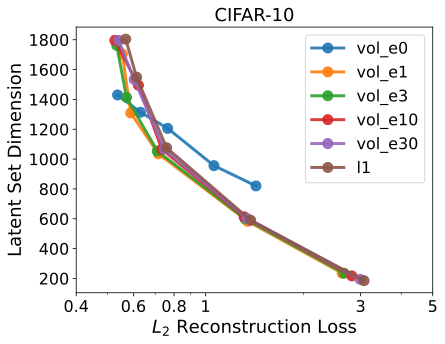

In [19]:
src = '../saves/image/'
dataset_name = 'cifar10'


lams = np.asarray([1e-2, 3e-3, 1e-3, 3e-4, 1e-4])
prefixes = ['e0.0_', 'e1.0_', 'e3.0_', 'e10.0_', 'e30.0_']
suffixes = ['_e0', '_e1', '_e3', '_e10', '_e30']
metrics = ['l2_non', 'l2_all', 'l2_cum_a', 'l2_each', 'z_std']
group = 'vol'

for prefix, suffix in zip(prefixes, suffixes):
    dir = os.path.join(src, dataset_name, group)
    l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, prefix)
    rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
    plt.plot(l2_non, rank, 'o-', label=group+suffix, alpha=0.9)

dir = os.path.join(src, dataset_name, 'l1')
l2_non, l2_all, l2_cum_a, l2_each, z_std = load_metrics(dir, metrics, '')
rank = dr_rank(l2_cum_a, l2_non, l2_all, 0.01)
plt.plot(l2_non, rank, 'o-', label='l1', alpha=0.9)

plt.xscale('log')
plt.xticks([0.4, 0.6, 0.8, 1, 3, 5], [0.4, 0.6, 0.8, 1, 3, 5])
plt.xlim
plt.legend()
plt.xlabel('$L_2$ Reconstruction Loss')
plt.ylabel('Latent Set Dimension')
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.title('CIFAR-10')
plt.show()